# **Importação das Bibliotecas**

In [1]:
from typing import List, Tuple, Union

import polars as pl
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

# **Definição das Funções**

In [2]:
def adjusted_barplot(data: pl.DataFrame, x: str, y: str, xlabel: str, ylabel: str, title: str,
                     legend: Union[None, str]=None, hue: Union[None, str]=None, palette: Union[None, str, List[str]]=None, 
                     color: Union[None, str]=None, figsize: Tuple=(12,6), x_rotation: int=45) -> None:
    """Plot adjusted bar chart.

    Args:
        data (pl.DataFrame): DataFrame with the data.
        x (str): x-axis column.
        y (str): y-axis column
        xlabel (str): x-axis name
        ylabel (str): y-axis name
        title (str): Chart title.
        legend (Union[None, str], optional): Legend name. Defaults to None.
        hue (Union[None, str], optional): Name of the column that defines the color grouping for the bars. Defaults to None.
        palette (Union[None, str, List[str]], optional): Bar color palette (when hue is different from None). Defaults to None.
        color (Union[None, str], optional): Color of bars when hue is None. Defaults to None.
    
    Returns:
        None
    """
    
    plt.figure(figsize=figsize)
    barplot = sns.barplot(data=data, x=x, y=y, hue=hue, palette=palette, color=color)
    plt.xticks(rotation=x_rotation)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(title=legend)
    plt.title(title)

    for p in barplot.patches:
        height = p.get_height()
        if height != 0:
            barplot.annotate(
                format(height, ".2f"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center", 
                va="center",
                xytext=(0, 8),
                textcoords="offset points",
                color=p.get_facecolor()
            )

    plt.show()

# **Leitura dos Dados**

In [3]:
models_results = pl.read_parquet("../data/08_reporting/models_results.pq")
models_results.sample(5, seed=42)

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64
"""03_26""","""03""","""26""","""original""","""ARIMA""",42.21674,0.161071,0.199736,0.732478
"""03_20""","""03""","""20""","""original""","""Prophet""",79.94293,0.21161,0.253294,1.010426
"""08_08""","""08""","""08""","""original""","""FourTheta""",6.226967,0.154755,0.181331,0.952217
"""02_08""","""02""","""08""","""original""","""SimpleMovingAv…",0.074281,0.162337,0.19611,0.977138
"""03_36""","""03""","""36""","""original""","""N-HiTS""",184.933801,0.181111,0.217783,0.922887


# **Análises**

- Tempo total de execução (12 núcleos com paralelismo): 2 horas, 6 minutos e 7 segundos

## **Média e mediana dos resultados por modelo**

In [4]:
cols = ["execution_time", "smape", "rmsle", "owa"]

analysis = models_results.group_by("model").agg(
    *[pl.col(col).mean().alias(f"{col}_mean") for col in cols],
    *[pl.col(col).median().alias(f"{col}_median") for col in cols]
)

analysis.sample(5)

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""TiDE""",432.043482,0.203671,0.251982,1.013318,456.784233,0.196853,0.245758,1.015571
"""XGBoost""",80.004782,0.122266,0.150753,0.59736,77.99652,0.114887,0.14266,0.59435
"""N-HiTS""",187.905174,0.193516,0.235772,0.949147,186.873937,0.192145,0.23444,0.933906
"""FourTheta""",6.491619,0.180019,0.215701,0.87576,6.478971,0.178062,0.209049,0.881191
"""Prophet""",90.58221,0.201838,0.243609,0.960994,88.303814,0.196465,0.237108,0.98012


### **Ordenado pelo tempo de execução**

In [5]:
analysis.sort("execution_time_median")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""SimpleMovingAv…",0.100423,0.195123,0.234599,0.965405,0.094224,0.190538,0.228891,0.969003
"""FourTheta""",6.491619,0.180019,0.215701,0.87576,6.478971,0.178062,0.209049,0.881191
"""ExponentialSmo…",38.202731,0.188104,0.228497,0.919313,26.103199,0.186045,0.226196,0.919809
"""ARIMA""",37.319441,0.183883,0.224275,0.899747,34.033854,0.179357,0.216802,0.908929
"""XGBoost""",80.004782,0.122266,0.150753,0.59736,77.99652,0.114887,0.14266,0.59435
"""Prophet""",90.58221,0.201838,0.243609,0.960994,88.303814,0.196465,0.237108,0.98012
"""N-HiTS""",187.905174,0.193516,0.235772,0.949147,186.873937,0.192145,0.23444,0.933906
"""TiDE""",432.043482,0.203671,0.251982,1.013318,456.784233,0.196853,0.245758,1.015571


In [6]:
df_time = analysis.sort("execution_time_median").melt(
    id_vars="model", 
    value_vars=["execution_time_mean", "execution_time_median"], 
    variable_name="execution_time", 
    value_name="value"
)

df_time.sample(5, seed=42)

model,execution_time,value
str,str,f64
"""ARIMA""","""execution_time…",37.319441
"""FourTheta""","""execution_time…",6.478971
"""TiDE""","""execution_time…",432.043482
"""ExponentialSmo…","""execution_time…",38.202731
"""Prophet""","""execution_time…",90.58221


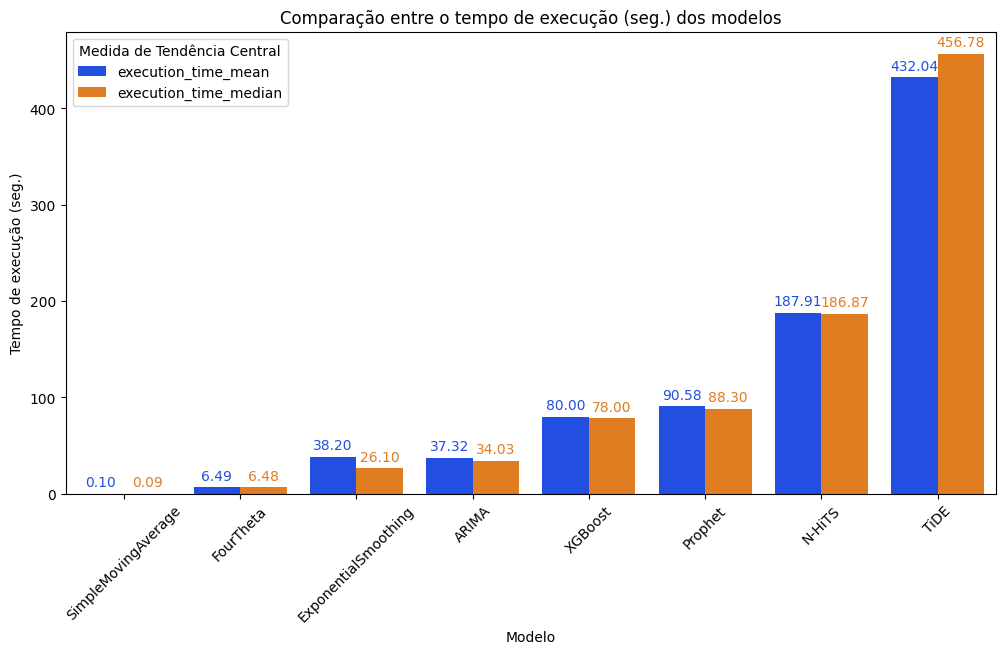

In [7]:
adjusted_barplot(
    data=df_time, x="model", y="value", hue="execution_time", palette="bright",
    xlabel="Modelo", ylabel="Tempo de execução (seg.)", legend="Medida de Tendência Central",
    title="Comparação entre o tempo de execução (seg.) dos modelos"
)

- Os resultados das médias e medianas foram bastante semelhantes, sugerindo a ausência de muitos outliers no tempo de execução.
- O TiDE destacou-se como o modelo mais lento, ao passo que o Média Móvel Simples (Simple Moving Average) foi o mais rápido.

### **Ordenado pela OWA**

#### **Média**

In [8]:
analysis.sort("owa_mean")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",80.004782,0.122266,0.150753,0.59736,77.99652,0.114887,0.14266,0.59435
"""FourTheta""",6.491619,0.180019,0.215701,0.87576,6.478971,0.178062,0.209049,0.881191
"""ARIMA""",37.319441,0.183883,0.224275,0.899747,34.033854,0.179357,0.216802,0.908929
"""ExponentialSmo…",38.202731,0.188104,0.228497,0.919313,26.103199,0.186045,0.226196,0.919809
"""N-HiTS""",187.905174,0.193516,0.235772,0.949147,186.873937,0.192145,0.23444,0.933906
"""Prophet""",90.58221,0.201838,0.243609,0.960994,88.303814,0.196465,0.237108,0.98012
"""SimpleMovingAv…",0.100423,0.195123,0.234599,0.965405,0.094224,0.190538,0.228891,0.969003
"""TiDE""",432.043482,0.203671,0.251982,1.013318,456.784233,0.196853,0.245758,1.015571


In [9]:
df_metrics_mean = analysis.sort("owa_mean").melt(
    id_vars="model", 
    value_vars=["smape_mean", "rmsle_mean", "owa_mean"], 
    variable_name="metric_mean", 
    value_name="value"
)

df_metrics_mean.sample(5, seed=42)

model,metric_mean,value
str,str,f64
"""TiDE""","""owa_mean""",1.013318
"""ExponentialSmo…","""smape_mean""",0.188104
"""Prophet""","""owa_mean""",0.960994
"""SimpleMovingAv…","""smape_mean""",0.195123
"""N-HiTS""","""rmsle_mean""",0.235772


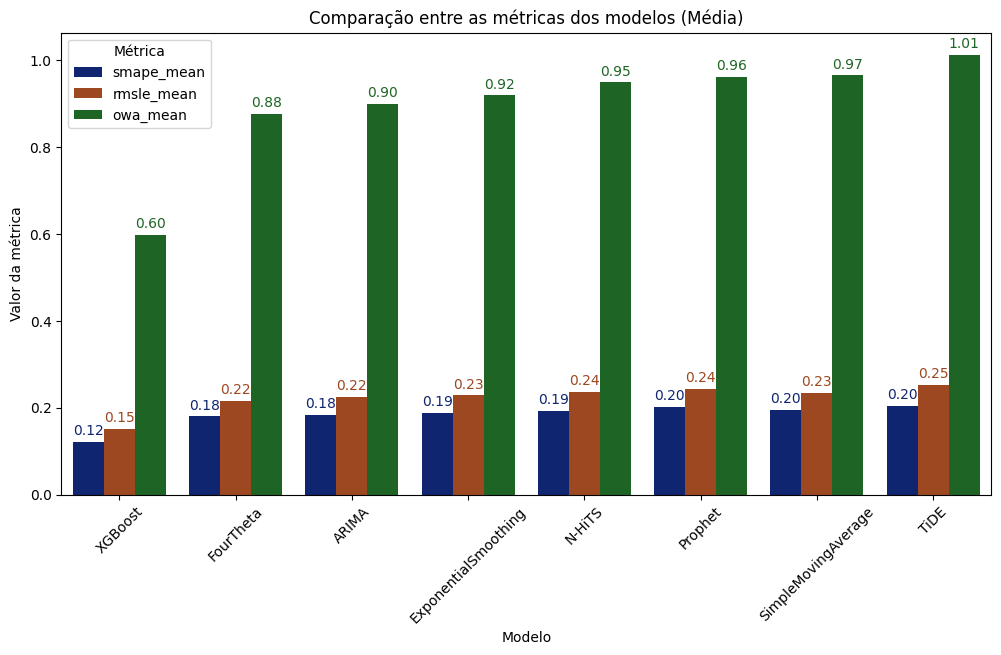

In [10]:
adjusted_barplot(
    data=df_metrics_mean, x="model", y="value", hue="metric_mean", palette="dark",
    xlabel="Modelo", ylabel="Valor da métrica", legend="Métrica",
    title="Comparação entre as métricas dos modelos (Média)"
)

#### **Mediana**

In [11]:
analysis.sort("owa_median")

model,execution_time_mean,smape_mean,rmsle_mean,owa_mean,execution_time_median,smape_median,rmsle_median,owa_median
str,f64,f64,f64,f64,f64,f64,f64,f64
"""XGBoost""",80.004782,0.122266,0.150753,0.59736,77.99652,0.114887,0.14266,0.59435
"""FourTheta""",6.491619,0.180019,0.215701,0.87576,6.478971,0.178062,0.209049,0.881191
"""ARIMA""",37.319441,0.183883,0.224275,0.899747,34.033854,0.179357,0.216802,0.908929
"""ExponentialSmo…",38.202731,0.188104,0.228497,0.919313,26.103199,0.186045,0.226196,0.919809
"""N-HiTS""",187.905174,0.193516,0.235772,0.949147,186.873937,0.192145,0.23444,0.933906
"""SimpleMovingAv…",0.100423,0.195123,0.234599,0.965405,0.094224,0.190538,0.228891,0.969003
"""Prophet""",90.58221,0.201838,0.243609,0.960994,88.303814,0.196465,0.237108,0.98012
"""TiDE""",432.043482,0.203671,0.251982,1.013318,456.784233,0.196853,0.245758,1.015571


In [12]:
df_metrics_median = analysis.sort("owa_median").melt(
    id_vars="model", 
    value_vars=["smape_median", "rmsle_median", "owa_median"], 
    variable_name="metric_median", 
    value_name="value"
)

df_metrics_median.sample(5, seed=42)

model,metric_median,value
str,str,f64
"""TiDE""","""owa_median""",1.015571
"""ExponentialSmo…","""smape_median""",0.186045
"""SimpleMovingAv…","""owa_median""",0.969003
"""Prophet""","""smape_median""",0.196465
"""N-HiTS""","""rmsle_median""",0.23444


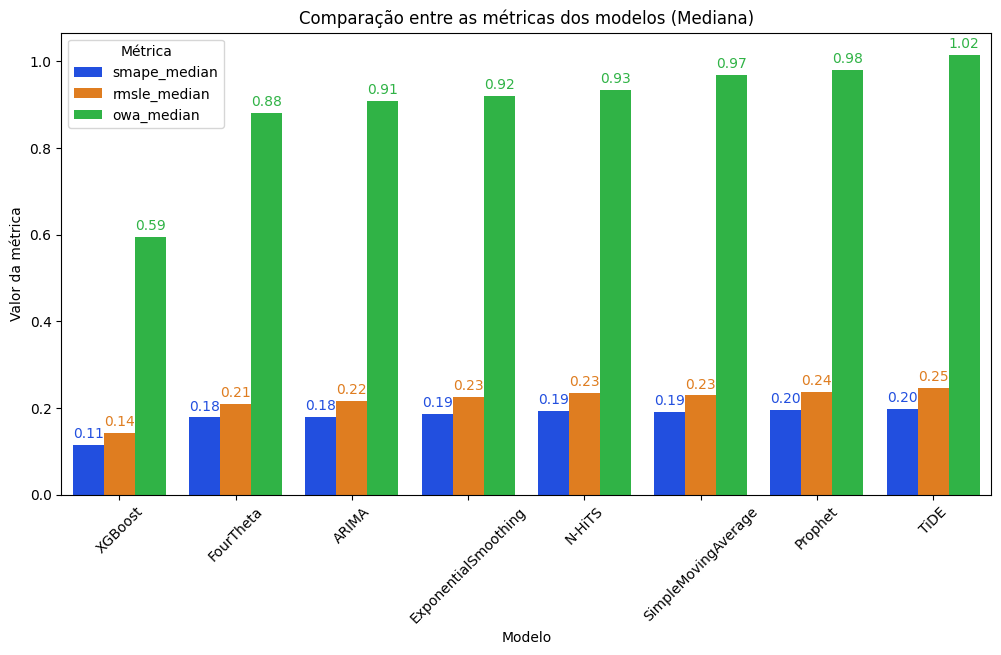

In [13]:
adjusted_barplot(
    data=df_metrics_median, x="model", y="value", hue="metric_median", palette="bright",
    xlabel="Modelo", ylabel="Valor da métrica", legend="Métrica",
    title="Comparação entre as métricas dos modelos (Mediana)"
)

- Além de ser o modelo mais lento, o TiDE também apresentou a pior média em todas as métricas.
- Por outro lado, o XGBoost foi o modelo que alcançou as melhores médias em todas as métricas.
- Durante a comparação das médias, o Prophet superou a Média Móvel Simples na OWA; no entanto, esse cenário se inverteu durante a comparação das medianas. Considerando que a Média Móvel Simples apresenta métricas sMAPE e RMLSE superiores em ambos os casos, essa diferença na OWA pode ter ocorrido devido à presença de algum outlier.

## **Melhor modelo por unique_id**

In [14]:
with open("../conf/base/parameters.yml", "r") as file:
    parameters = yaml.safe_load(file)

In [15]:
key_metric = parameters.get("KEY_METRIC")
def find_lower_metric(group):
    lower_metric_index = group[key_metric].arg_min()
    return group[lower_metric_index]

grouped = models_results.group_by("unique_id", maintain_order=True)
best_models = grouped.map_groups(find_lower_metric).drop_nulls().sort("unique_id")

best_models

unique_id,store,item,transformation,model,execution_time,smape,rmsle,owa
str,str,str,str,str,f64,f64,f64,f64
"""01_04""","""01""","""04""","""original""","""XGBoost""",76.955125,0.177921,0.213393,0.884896
"""01_13""","""01""","""13""","""original""","""XGBoost""",84.290343,0.087477,0.115043,0.430156
"""01_14""","""01""","""14""","""original""","""XGBoost""",77.113153,0.100949,0.125185,0.521255
"""01_16""","""01""","""16""","""original""","""XGBoost""",75.554999,0.20639,0.242604,0.602117
"""01_17""","""01""","""17""","""original""","""XGBoost""",73.255564,0.144145,0.174854,0.599877
…,…,…,…,…,…,…,…,…
"""10_31""","""10""","""31""","""original""","""XGBoost""",77.825269,0.09603,0.11736,0.564081
"""10_34""","""10""","""34""","""original""","""XGBoost""",73.930445,0.127828,0.156088,0.702785
"""10_37""","""10""","""37""","""original""","""XGBoost""",85.099006,0.127168,0.155762,0.607499


In [16]:
best_models["model"].value_counts()

model,count
str,u32
"""XGBoost""",100


- Considerando que o XGBoost foi consistentemente o melhor modelo em todos os casos (100), é razoável presumir que as séries temporais analisadas apresentaram um menor resíduo ao utilizá-lo. Isso sugere que o uso de modelos do tipo *ensemble* para a previsão dessas séries temporais deve ser avaliado, dada a superioridade de desempenho desses modelos nos casos analisados. É importante observar que esses modelos não possuem a capacidade de analisar tendências e/ou sazonalidades das séries temporais, características essenciais para os modelos desenvolvidos para esse propósito.